# Classify each building block as an acceptor or donor

Classification is based on comparing the HOMO of each unit to the HOMO of thiophene. sTD-DFT-xTB was performed and using a calibration curve, the B3LYP HOMO was obtained. Thiophene's HOMO using B3LYP is -6.5467 eV.

In [5]:
import glob
import pandas as pd
import os.path
from rdkit.Chem import Descriptors
from rdkit import Chem

In [6]:
def parse_sTDA(filename):
    
    with open(filename, 'r', encoding = 'utf-8') as file:
        line = file.readline()
        while line:
            if 'Koopmans IP (eV)' in line:
                line_list = line.split()
                HOMO = line_list[-1]
                HOMO = float(HOMO) * -1
            line = file.readline()  
        line = file.readline()
        return HOMO
    
def get_smiles(unit_name):
    smi_term = unit_name + '_TL.smi'
    smi_core = unit_name + '_C.smi'
    

    if os.path.exists('fragment_mols/SMILES/' + smi_term) == True:
        with open('fragment_mols/SMILES/' + smi_term, 'r', encoding = 'utf-8') as file:
            smiles = file.readline() 
            smiles = smiles.split('\t')[0]
        return smi_term, smiles
    
    elif os.path.exists('fragment_mols/SMILES/' + smi_core) == True:
        with open('fragment_mols/SMILES/' + smi_core, 'r', encoding = 'utf-8') as file:
            smiles = file.readline()
            smiles = smiles.split('\t')[0]
        return smi_core, smiles
    
    else:
        return False


thiophene_HOMO = -6.5467


In [77]:
column_names = ['fragment_number', 'smi_filename', 'smiles', 'sTDDFTxtb_HOMO', 'B3LYP_HOMO', 'A_or_D']
df = pd.DataFrame(columns = column_names)

terminal_count = 0
core_count = 0

for unit in glob.iglob('fragment_mols/sTDDFTxtb/*.out'):
    unit_name = unit.split('\\')[-1].split('.')[0]
    if get_smiles(unit_name) != False:
        data = []
        
        smi_filename, smiles = get_smiles(unit_name)
        
        if 'T' in smi_filename:
            terminal_count +=1
        else:
            core_count +=1
        
        sTDDFTxtb_HOMO = float(parse_sTDA(unit))
        B3LYP_HOMO = 0.737*sTDDFTxtb_HOMO + 4.637
        
        if B3LYP_HOMO <= thiophene_HOMO:
            A_or_D = 'A'
            
        else:
            A_or_D = 'D'
    
        data.extend([unit_name, smi_filename, smiles, sTDDFTxtb_HOMO, B3LYP_HOMO, A_or_D])
        
        df.loc[len(df.index)] = data

In [70]:
df

,fragment_number,smi_filename,smiles,sTDDFTxtb_HOMO,B3LYP_HOMO,A_or_D
0,0,0_TL.smi,C(=C1C(=O)c2cc(F)c(F)cc2C1=C(C#N)C#N),-16.456,-7.491072,A
1,1,1_TL.smi,C(=C1C(=O)c2ccccc2C1=C(C#N)C#N),-16.284,-7.364308,A
2,10,10_TL.smi,C(=C1C(=O)N(CC)C(=S)N(CC)C1=O),-14.764,-6.244068,D
3,100,100_C.smi,c1cc2C(CC)(CC)c3c(-c2cc1)ccc(c3),-15.072,-6.471064,D
4,101,101_C.smi,c1cc2C(=O)NC(=O)c3cc(cc(c1)c23),-15.743,-6.965591,A
...,...,...,...,...,...,...
372,95,95_C.smi,c1sc2c3c(c4cc(C(=O)CC)sc4c2c1)cc(s3),-14.245,-5.861565,D
373,96,96_C.smi,c1cc2sc3-c4c(c5ccc(CC)s5)c5C(c6ccc(CC)cc6)(c6c...,-13.309,-5.171733,D
374,97,97_TL.smi,C(=C1C(=O)c2cc3ccsc3cc2C1=C(C#N)C#N),-15.303,-6.641311,A
375,98,98_TL.smi,C(=C1C(=O)c2cc3cc(Br)sc3cc2C1=C(C#N)C#N),-15.398,-6.711326,A


In [62]:
df.to_csv('classification_unit_A_or_D.csv')

Lets see the distribution between acceptor and donor units

In [63]:
df['A_or_D'].value_counts()

D    267
A    110
Name: A_or_D, dtype: int64

There are 267 donor units and 100 acceptor units

In [78]:
print('Number of terminal units: ' + str(terminal_count))
print('Number of core units: ' + str(core_count))

Number of terminal units: 69
Number of core units: 308


### Make csvs for cores and terminals that contain AorD and fused ring count (will manually have to add it)

In [7]:
def get_A_or_D(unit_name):
    unit = unit_name.split('_')[0]
    filename = 'fragment_mols/sTDDFTxtb/' + unit + '.out'
    sTDDFTxtb_HOMO = float(parse_sTDA(filename))

    B3LYP_HOMO = 0.737*sTDDFTxtb_HOMO + 4.637

    if B3LYP_HOMO <= thiophene_HOMO:
        return sTDDFTxtb_HOMO, B3LYP_HOMO, 'A'

    else:
        return sTDDFTxtb_HOMO, B3LYP_HOMO, 'D'

In [416]:
column_names = ['smi_filename', 'smiles', 'sTDDFTxtb_HOMO', 'B3LYP_HOMO', 'A_or_D']
df_left_term = pd.DataFrame(columns = column_names)
df_right_term = pd.DataFrame(columns = column_names)
df_core = pd.DataFrame(columns = column_names)
mols = []

for smi in glob.iglob('fragment_mols/SMILES/*.smi'):
    
    with open(smi, 'r', encoding = 'utf-8') as file:
            smiles = file.readline()
            smiles = smiles.split('\t')[0]
                
    unit_name = smi.split('\\')[-1].split('.')[0]
    sTDDFTxtb_HOMO, B3LYP_HOMO, A_or_D = get_A_or_D(unit_name)
    
    mols.append([unit_name, smiles])
    
    data = []
    data.extend([unit_name, smiles, sTDDFTxtb_HOMO, B3LYP_HOMO, A_or_D])
    
    if '_TL' in unit_name:
        df_left_term.loc[len(df_left_term.index)] = data
        
    elif '_TR' in unit_name:
        df_right_term.loc[len(df_right_term.index)] = data
        
    else:
        df_core.loc[len(df_core.index)] = data


df_left_term.to_csv('left_terminals.csv')
df_right_term.to_csv('right_terminals.csv')
df_core.to_csv('cores.csv')

9_C


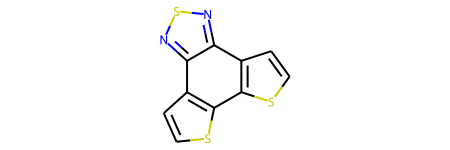

In [415]:
x = 446

print(mols[x][0])
smiles = mols[x][1]
mol = Chem.MolFromSmiles(smiles)
mol